# TRAVEL INSURANCE PREDICTION

## About the dataset 

The data is from a Tour & Travels Company which is Offering Travel Insurance Package to their Customers.
The New Insurance Package Also Includes Covid Cover.
The Company Requires To Know The Which Customers Would Be Interested To Buy It Based On Its Database History.
The Insurance Was Offered To Some Of The Customers In 2019 And The Given Data Has Been Extracted From The Performance/Sales Of The Package During That Period.
The Data Is Provided For Almost 2000 Of Its Previous Customers 
We And Are Required To Build An Intelligent Model That Can Predict If The Customer Will Be Interested To Buy The Travel Insurance Package Based On Certain Parameters Given Below.

Content

`Age` - Age Of The Customer

`Employment Type` - The Sector In Which Customer Is Employed

`GraduateOrNot` - Whether The Customer Is College Graduate Or Not

`AnnualIncome` - The Yearly Income Of The Customer In Indian Rupees[Rounded To Nearest 50 Thousand Rupees]

`FamilyMembers` - Number Of Members In Customer's Family

`ChronicDisease` - Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc.

`FrequentFlyer` - Derived Data Based On Customer's History Of Booking Air Tickets On Atleast 4 Different Instances In The Last 2 Years[2017-2019].

`EverTravelledAbroad`- Has The Customer Ever Travelled To A Foreign Country[Not Necessarily Using The Company's Services]

`TravelInsurance` - Did The Customer Buy Travel Insurance Package During Introductory Offering Held In The Year 2019.



## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from IPython.display import display, HTML
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold




## Loading Dataset and Overview

In [2]:

file_path = "TravelInsurancePrediction.csv"
df = pd.read_csv(file_path)

print("First five rows of the dataset:")
print(df.head(), "\n")

First five rows of the dataset:
   Unnamed: 0  Age               Employment Type GraduateOrNot  AnnualIncome  \
0           0   31             Government Sector           Yes        400000   
1           1   31  Private Sector/Self Employed           Yes       1250000   
2           2   34  Private Sector/Self Employed           Yes        500000   
3           3   28  Private Sector/Self Employed           Yes        700000   
4           4   28  Private Sector/Self Employed           Yes        700000   

   FamilyMembers  ChronicDiseases FrequentFlyer EverTravelledAbroad  \
0              6                1            No                  No   
1              7                0            No                  No   
2              4                1            No                  No   
3              3                1            No                  No   
4              8                1           Yes                  No   

   TravelInsurance  
0                0  
1                0

### Dataset structure

In [3]:

print("Dataset info:")
df.info()
print("\n")

df.shape

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1987 non-null   int64 
 1   Age                  1987 non-null   int64 
 2   Employment Type      1987 non-null   object
 3   GraduateOrNot        1987 non-null   object
 4   AnnualIncome         1987 non-null   int64 
 5   FamilyMembers        1987 non-null   int64 
 6   ChronicDiseases      1987 non-null   int64 
 7   FrequentFlyer        1987 non-null   object
 8   EverTravelledAbroad  1987 non-null   object
 9   TravelInsurance      1987 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 155.4+ KB




(1987, 10)

Our Dataset has 1987 rows and 10 columns

Dataset consists of 6 numerical features and 4 categorical features

### Summary Stats

In [4]:

print("Summary statistics (numerical and categorical):")
print(df.describe(include='all'), "\n")


Summary statistics (numerical and categorical):
         Unnamed: 0          Age               Employment Type GraduateOrNot  \
count   1987.000000  1987.000000                          1987          1987   
unique          NaN          NaN                             2             2   
top             NaN          NaN  Private Sector/Self Employed           Yes   
freq            NaN          NaN                          1417          1692   
mean     993.000000    29.650226                           NaN           NaN   
std      573.741812     2.913308                           NaN           NaN   
min        0.000000    25.000000                           NaN           NaN   
25%      496.500000    28.000000                           NaN           NaN   
50%      993.000000    29.000000                           NaN           NaN   
75%     1489.500000    32.000000                           NaN           NaN   
max     1986.000000    35.000000                           NaN          

### Missing Values

In [5]:

print("Missing values per column:")
print(df.isnull().sum(), "\n")


Missing values per column:
Unnamed: 0             0
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64 



No Missing Values identified.

### Dropping unnecesaary column "Unnamed"

In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)

### Checking for and Handling Duplicates

In [7]:

duplicates = df.duplicated().sum()
duplicates


738

738 duplicates found. I will handle these by removing them. 

#### Removing Duplicates

In [8]:

df_cleaned = df.drop_duplicates().reset_index(drop=True)

df_cleaned.shape


(1249, 9)

Our Cleaned Dataset has 1249 rows and 9 columns


### Categorical features

In [9]:

cat_cols = df_cleaned.select_dtypes(include=['object']).columns
print("Unique values in categorical columns:")
for col in cat_cols:
    print(f"{col}: {df[col].unique()}")


Unique values in categorical columns:
Employment Type: ['Government Sector' 'Private Sector/Self Employed']
GraduateOrNot: ['Yes' 'No']
FrequentFlyer: ['No' 'Yes']
EverTravelledAbroad: ['No' 'Yes']


### Numerical features

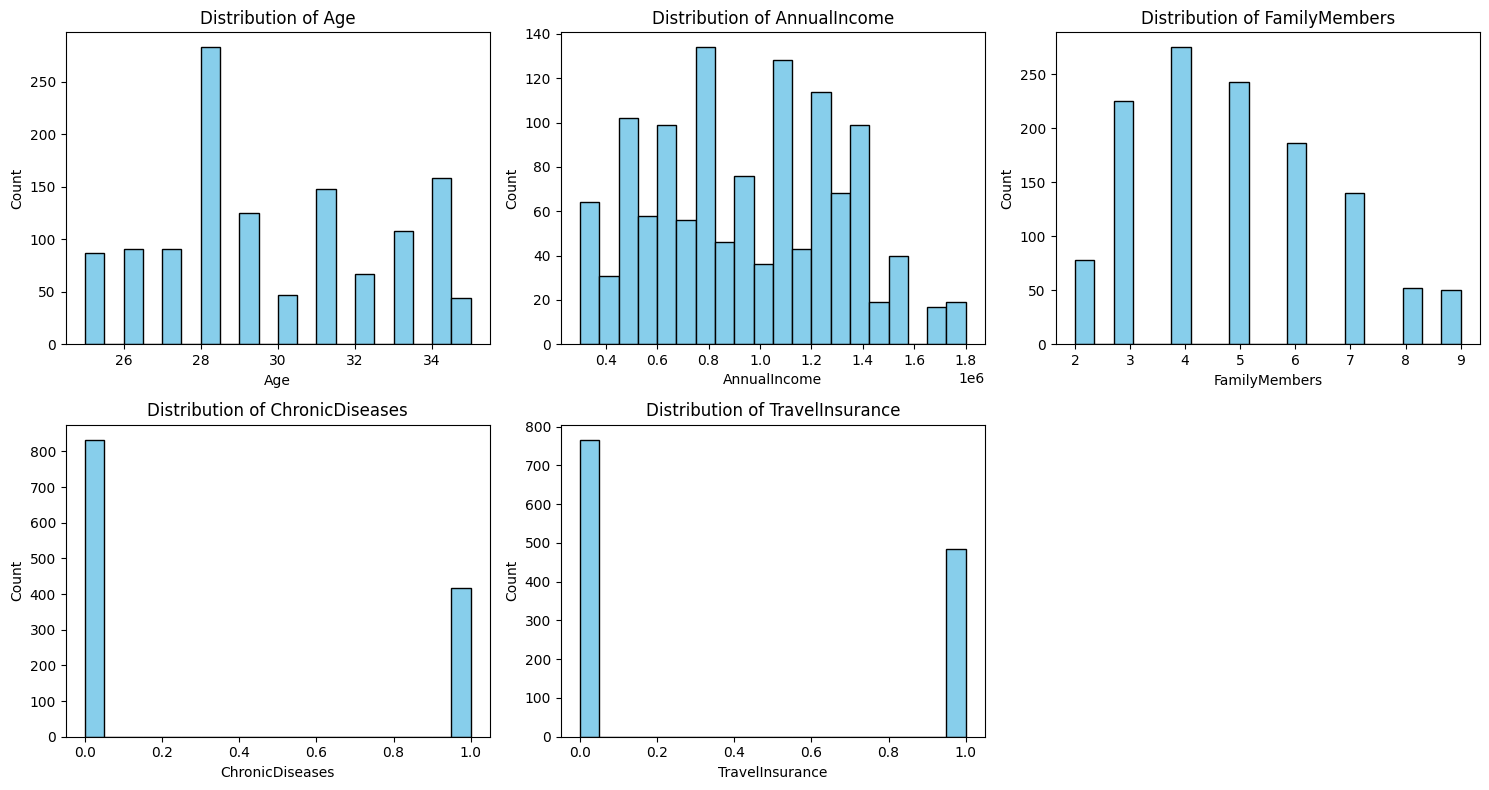

In [10]:

num_cols = df_cleaned.select_dtypes(include=[np.number]).columns
n_cols = 3  # Number of subplots per row
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    df_cleaned[col].hist(ax=axes[i], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].grid(False)


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Distribution Insights (Numerical Features)
**Age**
- The distribution is somewhat uniform with slight peaks at 28 and 34.

- Customers are mostly in their late 20s to mid 30s, indicating a young to mid-aged demographic.

**AnnualIncome**

- Income is broadly spread, with most customers earning between ₹6,00,000 and ₹13,00,000 per year.

- A small number of customers earn above ₹1,500,000, making them outliers and high income earners.

**FamilyMembers**

- The majority of customers have between 3 and 6 family members, peaking around 4.

- Very few customers report 2 or 9 members, making them less common household sizes.

**ChronicDiseases**, Highly imbalanced:

- Majority (≈85%) do not suffer from chronic diseases.

- This class imbalance might require attention if used in modeling.

**TravelInsurance (Target Variable)**, Also imbalanced:

- A large portion of customers did not purchase travel insurance (~70%).

- Reflects the real-world rarity of insurance uptake.

## EDA

### Converting categorical features to numerical

In [11]:
df_encoded = df_cleaned.copy()

binary_cols = ['GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']
df_encoded[binary_cols] = df_encoded[binary_cols].apply(lambda x: x.map({'Yes': 1, 'No': 0}))
   
df_encoded['ChronicDiseases'] = df_encoded['ChronicDiseases'].map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})
df_encoded['Employment Type'] = df_encoded['Employment Type'].map({'Government Sector': 0, 'Private Sector/Self Employed': 1})


### Correlation Heatmap

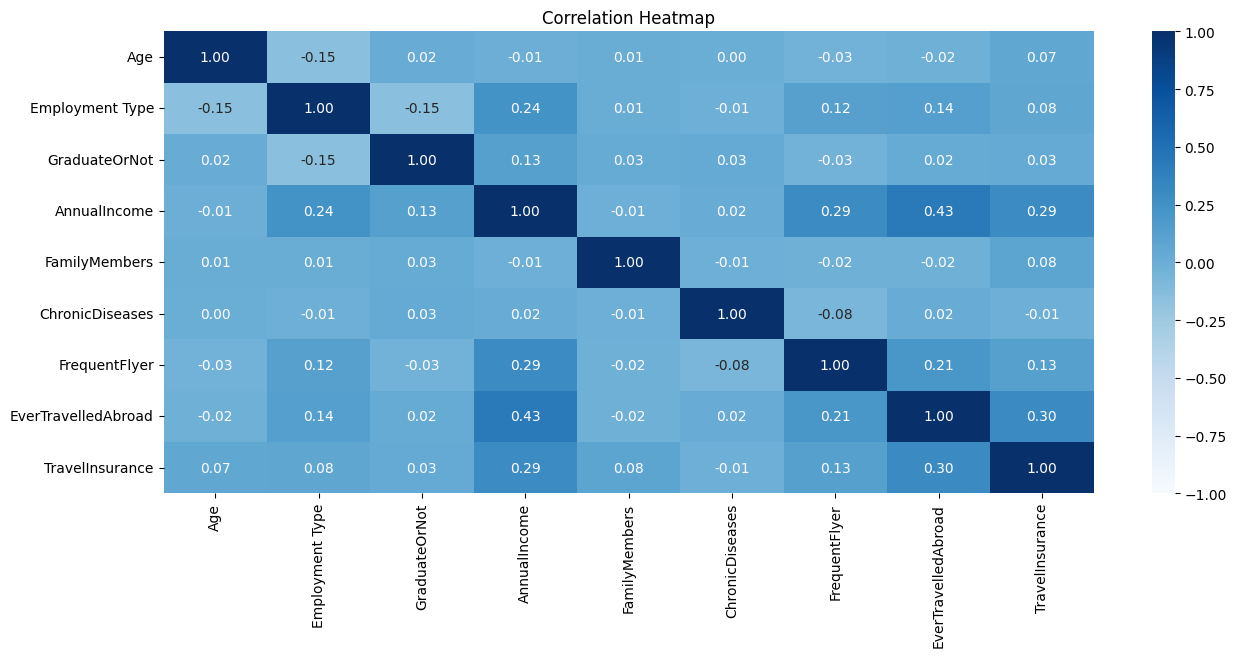

In [12]:
plt.figure(figsize=(15, 6))
sns.heatmap(df_encoded.corr(numeric_only=True), annot=True, cmap='Blues', fmt='.2f', vmax=1, vmin=-1)
plt.title('Correlation Heatmap')
plt.show()


#### Insights
- `AnnualIncome (0.29)` and `EverTravelledAbroad (0.30)` show strong positive correlations with the target TravelInsurance, reinforcing the idea that these variables significantly influence insurance purchases.

- `FrequentFlyer (0.13)` remains strongly positively correlated, indicating wealthier customers consistently purchase insurance more frequently.

- `Employment Type (0.08)`, `Age (0.07)` and `GraduateOrNot (0.03)` display lower, yet positive correlations, suggesting a smaller but notable influence on buying decisions.

- `ChronicDiseases (-0.01)` has negative correlation with target variable meaning it plays no role in Travel insurance buying.

- **Strong predictors**: Frequent flyer status, international travel experience, annual income, family size

- **Moderate predictors**: Employment type, educational status, Age

- **Weak predictors**: Chronic Diseases


### Binary features Against Target Variable

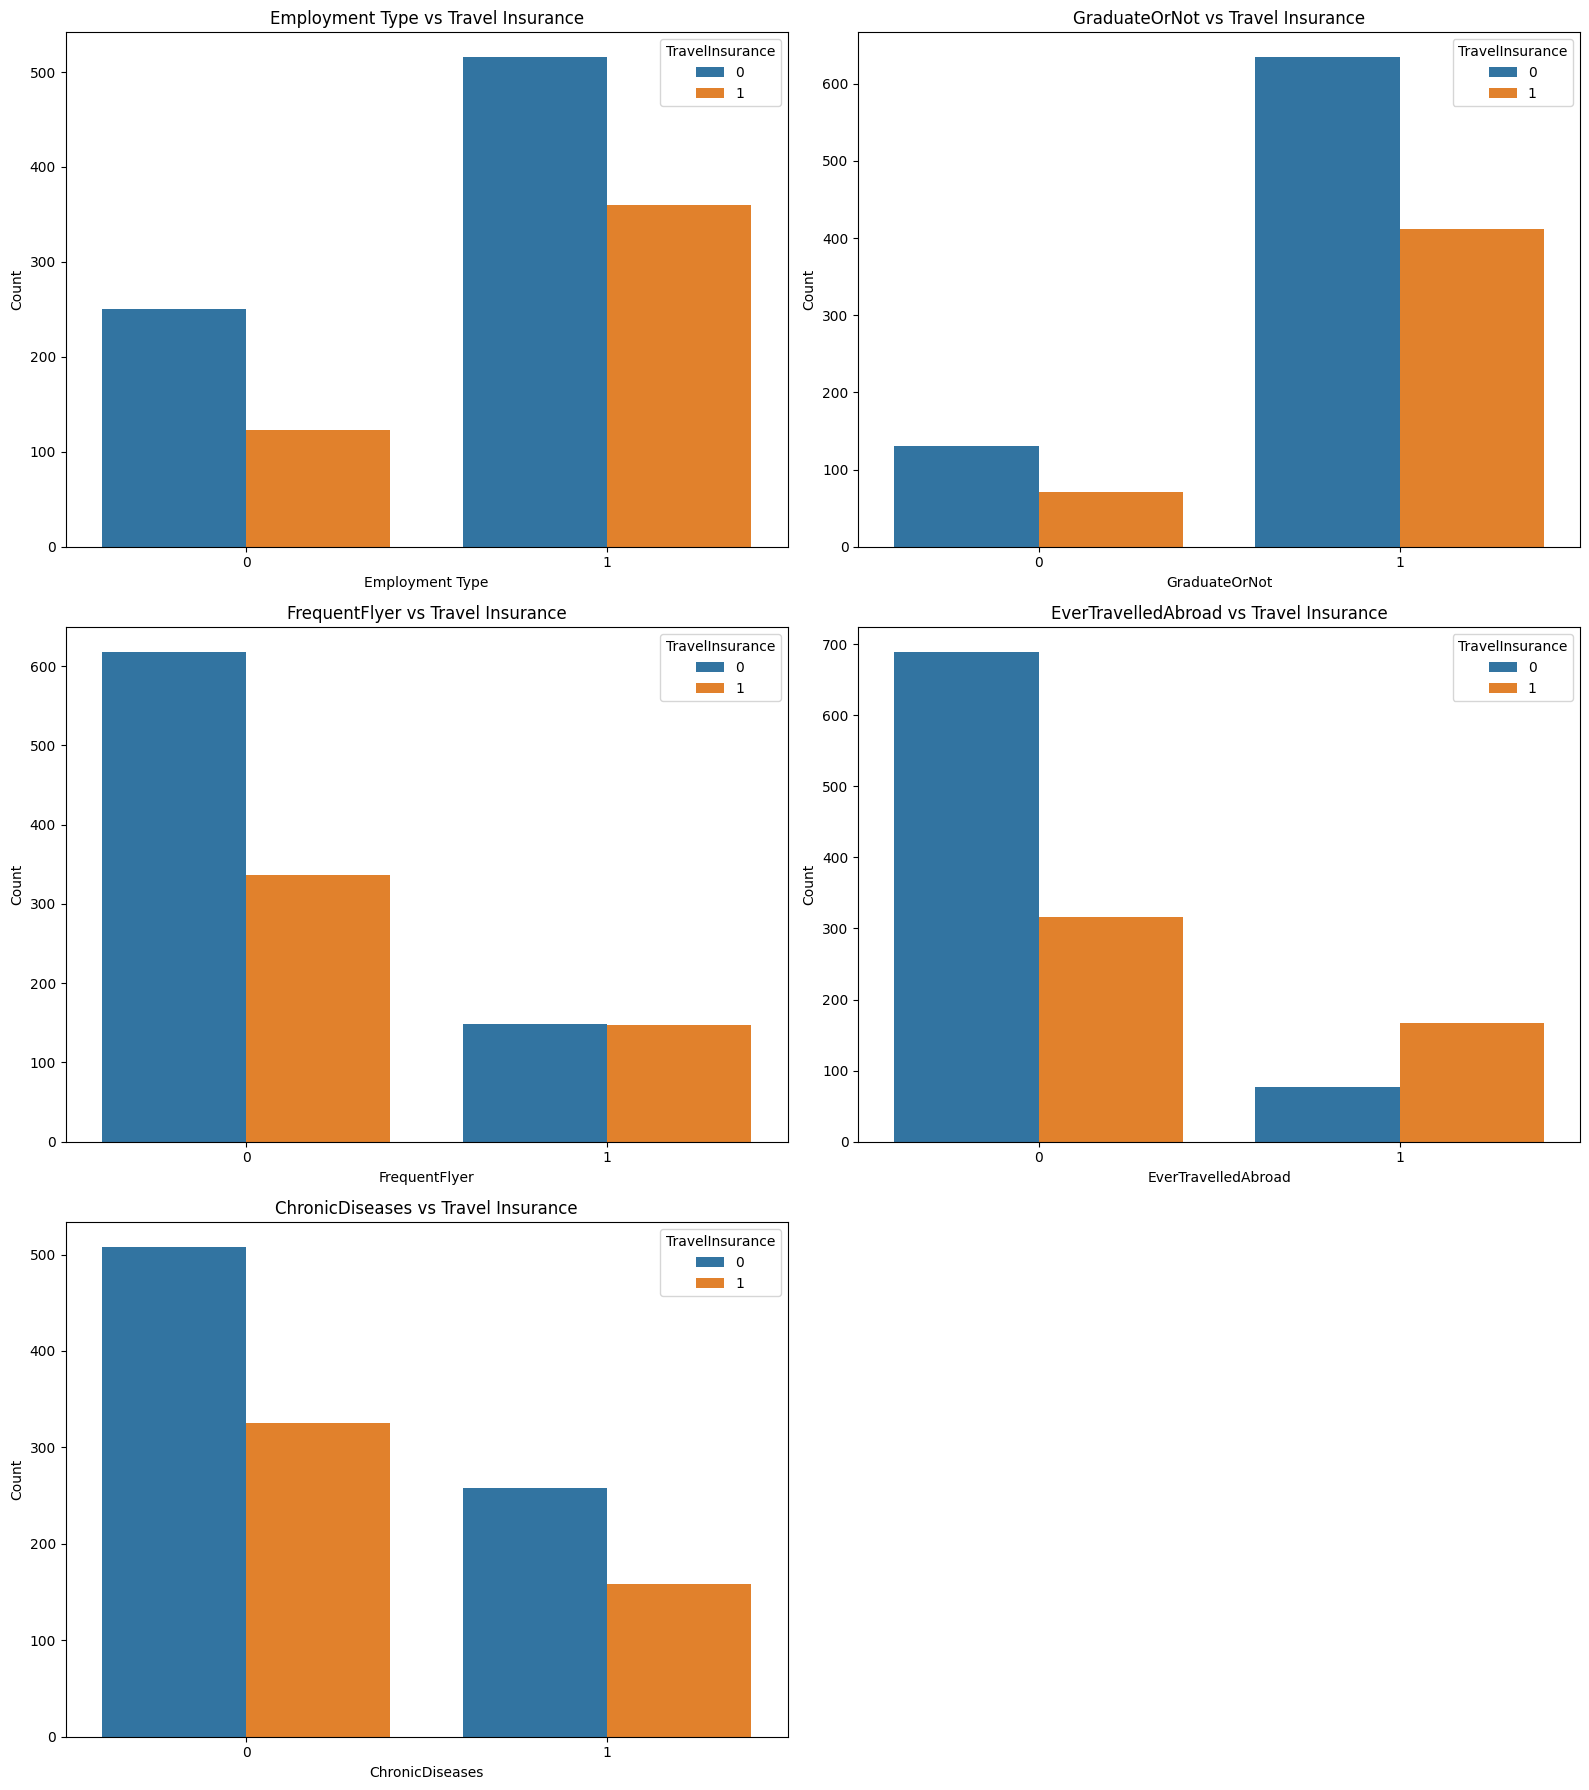

In [13]:
binary_cols = ['Employment Type', 'GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad', 'ChronicDiseases']
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()
for i, col in enumerate(binary_cols):
    sns.countplot(x=col, hue='TravelInsurance', data=df_encoded, ax=axes[i])
    axes[i].set_title(f'{col} vs Travel Insurance')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

**Employment Type**

- Private sector/self-employed customers clearly dominate the group buying insurance. The visual indicates that employment type remains an influential factor. 
- This could relate to differences in travel habits or income stability between sectors.

**GraduateOrNot**

- Graduates are notably more likely to buy insurance compared to non-graduates, though the difference is moderate. 
- This suggests education might indirectly reflect other factors like higher income or greater awareness of insurance benefits.

**FrequentFlyer**

- Customers identified as frequent flyers are strongly inclined towards purchasing travel insurance. 
- The stark contrast between frequent and non-frequent flyers underscores travel frequency as a robust predictor of insurance purchase.

**EverTravelledAbroad**

- A significant majority of customers who have traveled abroad previously opted for travel insurance. 
- This indicates prior international travel experience strongly influences the perceived necessity or value of insurance.

### Continous Numeric features against Target Variable

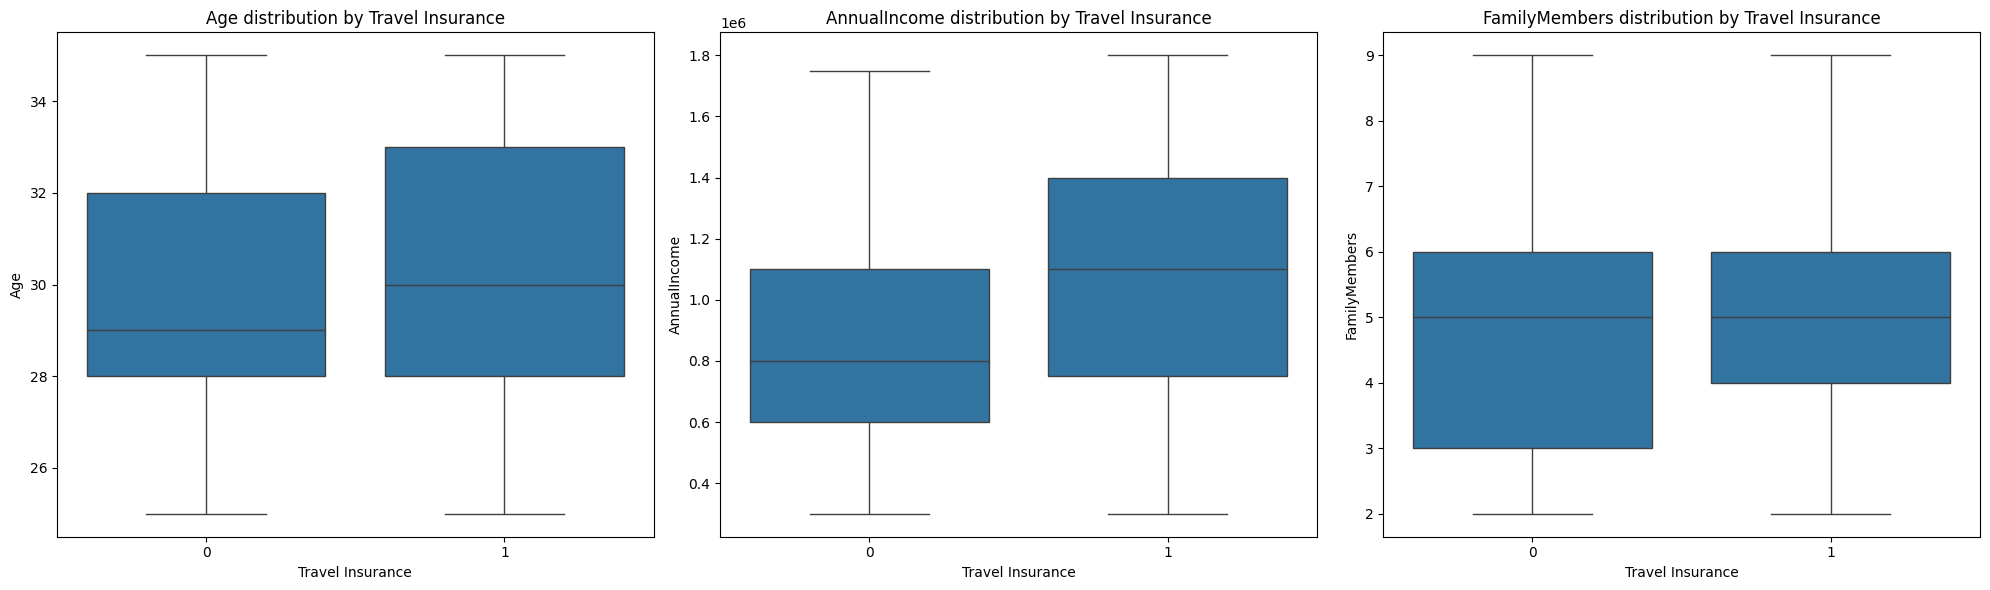

In [14]:
numerical_cols = ['Age', 'AnnualIncome', 'FamilyMembers']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, col in enumerate(numerical_cols):
    sns.boxplot(x='TravelInsurance', y=col, data=df_encoded, ax=axes[i])
    axes[i].set_title(f'{col} distribution by Travel Insurance')
    axes[i].set_xlabel('Travel Insurance')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

**Age**

- The distribution of age across insurance purchase categories remains quite similar, indicating age alone is not a major determinant in purchasing decisions. 
- Median ages are almost identical across both groups.

**Annual Income**

- Clearly differentiated distributions suggest customers who bought insurance generally have notably higher annual incomes. 
- This finding aligns with the stronger correlation observed after duplicate removal.

**Family Members**

- Family size distributions continue showing minimal differences between customers purchasing insurance and those not purchasing. 
- Hence, family size may not significantly influence travel insurance decisions.

## Statistical Inference

**Target Population** : Customers aged approximately 25–35 from the company's customer database in India who might consider buying travel insurance.

### Hypotheses

**Hypothesis 1 : Annual Income Effect**

- H₀ (Null Hypothesis): There is no difference in the mean annual income between customers who purchased travel insurance and those who didn't.

- H₁ (Alternative Hypothesis): Customers who purchase travel insurance have a higher mean annual income.

**Hypothesis 2: Frequent Flyer Status Effect**

- H₀ (Null Hypothesis): Frequent flyers and non-frequent flyers purchase travel insurance at the same proportion.

- H₁ (Alternative Hypothesis): Frequent flyers purchase travel insurance at a higher proportion.

**Hypothesis 3: International Travel Effect**

- H₀ (Null Hypothesis): Customers who have traveled abroad and those who haven't have equal proportions of travel insurance purchase.

- H₁ (Alternative Hypothesis): Customers who have traveled abroad have a higher proportion of travel insurance purchase.

**Hypothesis 4: Employment Sector Effect**

- H₀ (Null Hypothesis): The proportion of people buying travel insurance is equal for both employment types.

- H₁ (Alternative Hypothesis): People in the private/self-employed sector are more likely to purchase travel insurance.

 
`Significance level (α = 0.05)`.


### Hypothesis 1: Annual Income Effect

In [15]:
income_insurance = df_encoded[df_encoded['TravelInsurance'] == 1]['AnnualIncome']
income_no_insurance = df_encoded[df_encoded['TravelInsurance'] == 0]['AnnualIncome']

t_stat, p_val = ttest_ind(income_insurance, income_no_insurance, alternative='greater')

t_stat, p_val


(10.858502576114164, 1.309266960359086e-26)

- t-statistic: 10.86

- p-value: 1.31e-26 (extremely low)

Interpretation:

- Given the extremely low p-value (much smaller than the significance level α = 0.05), we reject the null hypothesis.

- This indicates a statistically significant difference, strongly supporting the conclusion that customers who purchase travel insurance typically have a significantly higher annual income.

### Hypothesis 2: Frequent Flyer Status

In [16]:
contingency_table = pd.crosstab(df_encoded['FrequentFlyer'], df_encoded['TravelInsurance'])

success_counts = np.array([
    contingency_table.loc[1, 1],
    contingency_table.loc[0, 1]
])

total_counts = np.array([
    contingency_table.loc[1].sum(),
    contingency_table.loc[0].sum()
])

z_stat, p_val = proportions_ztest(count=success_counts, nobs=total_counts, alternative='larger')

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.6f}")

Z-statistic: 4.5034
P-value: 0.000003


Interpretation:

Highly statistically significant. Frequent flyers purchase insurance at significantly higher rates.

### Hypothesis 3: International Travel Effect

In [17]:
contingency_table_abroad = pd.crosstab(df_encoded['EverTravelledAbroad'], df_encoded['TravelInsurance'])

success_counts = np.array([
    contingency_table_abroad.loc[1, 1],
    contingency_table_abroad.loc[0, 1]  
])

total_counts = np.array([
    contingency_table_abroad.loc[1].sum(),
    contingency_table_abroad.loc[0].sum() 
])

z_stat, p_val = proportions_ztest(count=success_counts, nobs=total_counts, alternative='larger')
z_stat, p_val


(10.645621536510593, 9.138024003260964e-27)

Z-statistic: 10.65

P-value: 9.14e-27
 
Since the p-value is much smaller than our significance level α=0.05, we strongly reject the null hypothesis.

This confirms that customers who have previously traveled abroad are significantly more likely to buy travel insurance.

### Hypothesis 4: Employment Sector Effect

In [18]:

contingency_table_employment = pd.crosstab(df_encoded['Employment Type'], df_encoded['TravelInsurance'])

success_counts = np.array([
    contingency_table_employment.loc[1, 1],
    contingency_table_employment.loc[0, 1]
])

total_counts = np.array([
    contingency_table_employment.loc[1].sum(),
    contingency_table_employment.loc[0].sum()
])

z_stat, p_val = proportions_ztest(count=success_counts, nobs=total_counts, alternative='larger')
z_stat, p_val

print(f"Z-statistic: {z_stat:.2f}")
print(f"P-value: {p_val:.4f}")

Z-statistic: 2.70
P-value: 0.0035


With a p-value well below α = 0.05, we reject the null hypothesis.

This provides statistically significant evidence that people in the private/self-employed sector are more likely to purchase travel insurance than those in government jobs.

## Predictive Models

### Data Processing

In [19]:

feature = ['Age', 'AnnualIncome', 'FamilyMembers',
                'Employment Type', 'GraduateOrNot',
                'FrequentFlyer', 'EverTravelledAbroad',
                'ChronicDiseases']
target = 'TravelInsurance'

X = df_encoded[feature]
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_distribution = y_train.value_counts(normalize=True)
test_distribution = y_test.value_counts(normalize=True)

train_distribution, test_distribution


(TravelInsurance
 0    0.613614
 1    0.386386
 Name: proportion, dtype: float64,
 TravelInsurance
 0    0.612
 1    0.388
 Name: proportion, dtype: float64)

**Train set distribution:**

- 61.4% → did not buy insurance

- 38.6% → bought insurance

**Test set distribution:**
- 61.2% → did not buy insurance

- 38.8% → bought insurance

This closely mirrors the original distribution — perfect for fair model evaluation.

#### Logistic Model

In [20]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test, has_constant='add')
X_test_const = X_test_const[X_train_const.columns]

logit_model = sm.Logit(y_train, X_train_const).fit(disp=False)

summary_df = logit_model.summary2().tables[1]
model_info = {
    'Log-Likelihood': logit_model.llf,
    'AIC': logit_model.aic
}
summary_df['Log-Likelihood'] = model_info['Log-Likelihood']
summary_df['AIC'] = model_info['AIC']

vif_data = pd.DataFrame()
vif_data['Feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif_data['Tolerance'] = 1 / vif_data['VIF']

display(HTML("<h3>Logistic Regression Coefficients and Stats</h3>"))
display(summary_df)

display(HTML("<h3>VIF and Tolerance Table</h3>"))
display(vif_data)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],Log-Likelihood,AIC
const,-4.741254,8.282867e-01,-5.724170,1.039406e-08,-6.364666e+00,-3.117842,-584.294383,1186.588766
Age,0.065002,2.409071e-02,2.698220,6.971143e-03,1.778510e-02,0.112219,-584.294383,1186.588766
AnnualIncome,0.000001,2.320810e-07,5.918095,3.256922e-09,9.186068e-07,0.000002,-584.294383,1186.588766
FamilyMembers,0.136889,3.979008e-02,3.440275,5.811228e-04,5.890170e-02,0.214876,-584.294383,1186.588766
Employment Type,0.127881,1.662804e-01,0.769069,4.418522e-01,-1.980225e-01,0.453785,-584.294383,1186.588766
GraduateOrNot,0.010883,2.021629e-01,0.053835,9.570667e-01,-3.853486e-01,0.407115,-584.294383,1186.588766
FrequentFlyer,0.167344,1.729102e-01,0.967809,3.331397e-01,-1.715537e-01,0.506242,-584.294383,1186.588766
EverTravelledAbroad,1.180952,1.937087e-01,6.096535,1.083919e-09,8.012898e-01,1.560614,-584.294383,1186.588766
ChronicDiseases,-0.095462,1.517936e-01,-0.628891,5.294203e-01,-3.929715e-01,0.202048,-584.294383,1186.588766


,Feature,VIF,Tolerance
0,Age,17.696013,0.056510
1,AnnualIncome,10.667579,0.093742
2,FamilyMembers,8.065322,0.123988
3,Employment Type,3.508488,0.285023
4,GraduateOrNot,6.316401,0.158318
5,FrequentFlyer,1.464020,0.683051
6,EverTravelledAbroad,1.572750,0.635829
7,ChronicDiseases,1.517350,0.659044


### Insights

**Strong predictors**

- AnnualIncome, p-value 3.26e-09 with positive coefficient higher income means more likely to buy insurance.

- EverTravelledAbroad, p-value 1.08e-09 and positive coefficient. Past travel experience increase insurance uptake.

**Weak Predictors**

- Age, p-value 0.0069. Small but significant effect — older customers more likely.

- FamilyMembers p-value 0.0006. Statistically significant — more family members slightly increase likelihood.

**Multi-Collinearity**

- Age (VIF = 17.70) and AnnualIncome (VIF = 10.67) show severe multicollinearity, with very low tolerance values (≈0.06–0.09). 
These features are strongly linearly dependent on other features in the dataset.

- FamilyMembers (VIF = 8.07) and GraduateOrNot (VIF = 6.32) indicate moderate multicollinearity, but not as critical as the top two.

- Remaining features (like FrequentFlyer, EverTravelledAbroad, ChronicDiseases) have VIFs well below 5, suggesting low risk of multicollinearity.

*Recommendation:*

- Consider dropping or transforming variables like Age or AnnualIncome if multicollinearity proves problematic.

- However, since I plan to dive into tree-based models like XGBoost which are not sensitive to multicollinearity, this is more of a diagnostic check than a mandatory fix.


#### Logistic Model Perfomance

In [21]:

y_prob = logit_model.predict(X_test_const)
y_pred = (y_prob >= 0.5).astype(int)

conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred),
                           columns=["Predicted 0", "Predicted 1"],
                           index=["Actual 0", "Actual 1"])

class_report = classification_report(y_test, y_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()

roc_auc = roc_auc_score(y_test, y_prob)

conf_matrix, class_report_df, roc_auc


(          Predicted 0  Predicted 1
 Actual 0          129           24
 Actual 1           62           35,
               precision    recall  f1-score  support
 0              0.675393  0.843137  0.750000  153.000
 1              0.593220  0.360825  0.448718   97.000
 accuracy       0.656000  0.656000  0.656000    0.656
 macro avg      0.634307  0.601981  0.599359  250.000
 weighted avg   0.643510  0.656000  0.633103  250.000,
 0.6452732295667407)

- The model is good at identifying who won't buy insurance (high recall for class 0).

- But it still misses many buyers (lower recall for class 1), indicating room for improvement, possibly via:
    - Feature engineering
    - Class balancing
    - More flexible models (e.g., tree ensembles)



### Random Forest

In [22]:
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

conf_matrix_rf = pd.DataFrame(confusion_matrix(y_test, y_pred_rf),
                              columns=["Predicted 0", "Predicted 1"],
                              index=["Actual 0", "Actual 1"])
class_report_rf = pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).transpose()
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

conf_matrix_rf, class_report_rf, roc_auc_rf

(          Predicted 0  Predicted 1
 Actual 0          114           39
 Actual 1           57           40,
               precision    recall  f1-score  support
 0              0.666667  0.745098  0.703704  153.000
 1              0.506329  0.412371  0.454545   97.000
 accuracy       0.616000  0.616000  0.616000    0.616
 macro avg      0.586498  0.578735  0.579125  250.000
 weighted avg   0.604456  0.616000  0.607030  250.000,
 0.5553197223906744)

#### Insights
**Weighted Precision - `(0.6045)`:**
- This indicates that when the model predicts a customer will buy insurance (positive class), it is correct approximately 60.5% of the time—taking into account the class distribution.

- Moderate precision suggests some degree of false positives, but not excessively high.

**Weighted Recall `(0.6160)`:** 
- The model correctly identifies approximately 61.6% of all actual insurance buyers. 

- This is a reasonable recall score, particularly in scenarios where missed opportunities (false negatives) matter—e.g., not identifying a customer who would have purchased.

**Weighted F1-Score `(0.6070)`:**
- The harmonic mean of precision and recall indicates a balanced performance between identifying actual buyers and limiting incorrect predictions.

- While not outstanding, this F1-score demonstrates the model has achieved a reasonable trade-off.

**ROC AUC Score `(0.5553)`:**
- The model's ability to distinguish between positive and negative classes is only marginally better than random guessing (0.5). 

- This may imply thresholding was not optimal for maximizing ROC AUC or that class separation is inherently weak in the feature space.

Overall the base logistic model had better perfomance in all the above mentioned metrics but due to class imbalance it's the model is always biased to the majority class.

#### Hyperparameters

In [23]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 24 candidates, totalling 120 fits


({'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_split': 5,
  'n_estimators': 100},
 0.6993755378301559)

AUC improvement 0.6994; a noticeable improvement from earlier (0.5583)

#### Countering class imbalance using best parameters

In [24]:
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
rf_balanced.fit(X_train, y_train)

y_pred_bal = rf_balanced.predict(X_test)
y_prob_bal = rf_balanced.predict_proba(X_test)[:, 1]

conf_matrix_bal = pd.DataFrame(confusion_matrix(y_test, y_pred_bal),
                               columns=["Predicted 0", "Predicted 1"],
                               index=["Actual 0", "Actual 1"])
class_report_bal = pd.DataFrame(classification_report(y_test, y_pred_bal, output_dict=True)).transpose()
roc_auc_bal = roc_auc_score(y_test, y_prob_bal)

conf_matrix_bal, class_report_bal, roc_auc_bal

(          Predicted 0  Predicted 1
 Actual 0          137           16
 Actual 1           55           42,
               precision    recall  f1-score  support
 0              0.713542  0.895425  0.794203  153.000
 1              0.724138  0.432990  0.541935   97.000
 accuracy       0.716000  0.716000  0.716000    0.716
 macro avg      0.718840  0.664207  0.668069  250.000
 weighted avg   0.717653  0.716000  0.696323  250.000,
 0.6650832154167509)

Overall better model performance all across the board

**Improvements after applying best parameters**

- `Weighted Precision` goes up from `0.6040 to 0.7177` *(+11.4%)*, more reliable in predicting true positives relative to false positives.

- `Weighted Recall` goes up from `0.6160 to 0.7160` *(+10.0%)*, A substantial improvement in the model’s ability to detect true positives (i.e., actual buyers of insurance), suggesting reduced customer leakage.

- `Weighted F1-Score` goes up from `0.6070 to 0.6963` *(+8.9%)*, better balance in precision and recall

- `AUC` goes up from `0.5553 to 0.6651` *(+11.0%)*, Reflects enhanced class separability, affirming the model's improved discriminative ability. 


### Gradient Boosting Model

In [25]:
gb_model = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

conf_matrix_gb = pd.DataFrame(confusion_matrix(y_test, y_pred_gb),
                              columns=["Predicted 0", "Predicted 1"],
                              index=["Actual 0", "Actual 1"])
class_report_gb = pd.DataFrame(classification_report(y_test, y_pred_gb, output_dict=True)).transpose()
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)

conf_matrix_gb, class_report_gb, roc_auc_gb

(          Predicted 0  Predicted 1
 Actual 0          104           49
 Actual 1           54           43,
               precision    recall  f1-score  support
 0              0.658228  0.679739  0.668810  153.000
 1              0.467391  0.443299  0.455026   97.000
 accuracy       0.588000  0.588000  0.588000    0.588
 macro avg      0.562810  0.561519  0.561918  250.000
 weighted avg   0.584183  0.588000  0.585862  250.000,
 0.5637423354221414)

#### Insights

- While GradientBoostingClassifier is a powerful algorithm, its default hyperparameter configuration here results in subpar generalization and predictive performance. 
- The classifier struggles to differentiate between the two classes, as evidenced by:

    - Low recall on class 1 (0.4433), indicating it misses over half of actual buyers.

    - Weak ROC AUC score (0.5637), suggesting near-random separability.

Try XGBoost for a more robust model.


### XGBoost Model

In [26]:
xgb_model = XGBClassifier(eval_metric='logloss',
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

conf_matrix_xgb = pd.DataFrame(confusion_matrix(y_test, y_pred_xgb),
                               columns=["Predicted 0", "Predicted 1"],
                               index=["Actual 0", "Actual 1"])
class_report_xgb = pd.DataFrame(classification_report(y_test, y_pred_xgb, output_dict=True)).transpose()
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)

conf_matrix_gb, class_report_xgb, roc_auc_xgb

(          Predicted 0  Predicted 1
 Actual 0          104           49
 Actual 1           54           43,
               precision    recall  f1-score  support
 0              0.668831  0.673203  0.671010  153.000
 1              0.479167  0.474227  0.476684   97.000
 accuracy       0.596000  0.596000  0.596000    0.596
 macro avg      0.573999  0.573715  0.573847  250.000
 weighted avg   0.595241  0.596000  0.595611  250.000,
 0.626137052759248)

#### Insights

**Balanced Performance for weighted averages :**
- Precision, recall, and F1-score are closely aligned, suggesting a balanced error trade-off. 
- However, all hover just below the 0.60 mark, indicating modest performance.

**ROC AUC Score (0.6261):**
- This value demonstrates better class separation compared to the GradientBoostingClassifier you ran earlier (which had 0.5637).

- This is consistent with XGBoost’s ability to capture non-linear relationships and interactions more effectively.

XGBoost outperforms the baseline Gradient Boosting in overall discriminative ability, as reflected in the AUC.

- However, without threshold optimization or resampling, the model underperforms on the minority class.

#### Class balancing, Over Sampling

In [27]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

xgb_sm_model = XGBClassifier(
    n_estimators=1000,
    max_depth=3,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)
xgb_sm_model.fit(X_train_sm, y_train_sm)

y_prob_sm = xgb_sm_model.predict_proba(X_test)[:, 1]
y_pred_sm = (y_prob_sm >= 0.5).astype(int)

conf_matrix_sm = pd.DataFrame(confusion_matrix(y_test, y_pred_sm),
                              columns=["Predicted 0", "Predicted 1"],
                              index=["Actual 0", "Actual 1"])
class_report_sm = pd.DataFrame(classification_report(y_test, y_pred_sm, output_dict=True)).transpose()
roc_auc_sm = roc_auc_score(y_test, y_prob_sm)

conf_matrix_sm, class_report_sm, roc_auc_sm

(          Predicted 0  Predicted 1
 Actual 0          115           38
 Actual 1           47           50,
               precision    recall  f1-score  support
 0              0.709877  0.751634  0.730159   153.00
 1              0.568182  0.515464  0.540541    97.00
 accuracy       0.660000  0.660000  0.660000     0.66
 macro avg      0.639029  0.633549  0.635350   250.00
 weighted avg   0.654899  0.660000  0.656587   250.00,
 0.7256586483390608)

#### Insights

**Substantial AUC Gain:**
- The AUC increased to 0.7257, a strong improvement over the pre-SMOTE XGBoost (0.6261).

- Indicates enhanced model capability in distinguishing between classes, especially the minority class.

**Balanced Weighted Metrics:**
-  All weighted metrics are now > 0.65, signifying that the model is more balanced and fairer across both classes after applying SMOTE.

- This is important in contexts where both false positives and false negatives carry cost.

There was overall improvements in class 1 metrics SMOTE effectively boosted the model's ability to correctly predict actual buyers.

### Model Ensemble

In [28]:
base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=500, random_state=42))
]

xgb_meta = XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.1, eval_metric='logloss')

stacked_model_xgb = StackingClassifier(
    estimators=base_learners,
    final_estimator=xgb_meta,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

'''Train the model on the SMOTE-augmented data''' 

stacked_model_xgb.fit(X_train_sm, y_train_sm)


y_pred_stack_xgb = stacked_model_xgb.predict(X_test)
y_prob_stack_xgb = stacked_model_xgb.predict_proba(X_test)[:, 1]

conf_matrix_stack_xgb = pd.DataFrame(
    confusion_matrix(y_test, y_pred_stack_xgb),
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)

class_report_stack_xgb = classification_report(y_test, y_pred_stack_xgb, output_dict=True)
class_report_stack_xgb_df = pd.DataFrame(class_report_stack_xgb).transpose()

roc_auc_stack_xgb = roc_auc_score(y_test, y_prob_stack_xgb)

conf_matrix_stack_xgb, class_report_stack_xgb_df, roc_auc_stack_xgb



(          Predicted 0  Predicted 1
 Actual 0          117           36
 Actual 1           45           52,
               precision    recall  f1-score  support
 0              0.722222  0.764706  0.742857  153.000
 1              0.590909  0.536082  0.562162   97.000
 accuracy       0.676000  0.676000  0.676000    0.676
 macro avg      0.656566  0.650394  0.652510  250.000
 weighted avg   0.671273  0.676000  0.672747  250.000,
 0.7166296071693282)

#### Insights
- Overall Improvements in weighted averages Compared to Earlier Models

- Best `recall for Class 1` so far `(53.6%)` among all ensemble setups — which is great for minimizing false negatives (i.e., missing potential buyers).

- Balanced precision (0.591) for class 1 means the model isn't just predicting too many false positives to get that recall.



#### Hyperparamter Tuning

In [29]:
xgb_bayes = XGBClassifier(eval_metric='logloss', random_state=42)

param_space = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.6, 1.0, 'uniform'),
    'colsample_bytree': (0.6, 1.0, 'uniform'),
    'gamma': (0, 5),
    'reg_alpha': (0, 1.0),
    'reg_lambda': (0, 1.0)
}

opt = BayesSearchCV(
    estimator=xgb_bayes,
    search_spaces=param_space,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_iter=50,
    n_jobs=-1,
    verbose=0,
    random_state=42
)

opt.fit(X_train_sm, y_train_sm)

print("Best parameters found: ", opt.best_params_)

Best parameters found:  OrderedDict([('colsample_bytree', 0.9911418236827858), ('gamma', 1), ('learning_rate', 0.01719672846298989), ('max_depth', 4), ('n_estimators', 567), ('reg_alpha', 0.0), ('reg_lambda', 0.992837000744604), ('subsample', 0.9424450682040877)])


#### Insights 

- `colsample_bytree	- 0.9911` : Nearly the full set of features is used per tree — the model benefits from most feature interactions.

- `gamma - 1`: A moderate level of regularization. A split must reduce loss by at least 1 — helps prevent overfitting.

- `learning_rate - 0.0172`:	Very conservative — slower learning allows the model to generalize better, but requires more trees.

- `max_depth - 4`: Shallow trees reduce model complexity and overfitting — good for generalization.

- `n_estimators - 567`: Compensates for the low learning rate — more trees are needed to capture patterns.

- `reg_lambda - 0.9928`: L2 regularization is nearly fully active — helps to reduce overfitting.

- `subsample - 0.9424`:	Each tree is trained on ~94% of the data — introduces beneficial randomness for generalization.

#### Tuned Ensemble

In [30]:
xgb_meta_best = XGBClassifier(
    n_estimators=567,
    max_depth=4,
    learning_rate=0.01719672846298989,
    gamma=1,
    subsample=0.9424450682040877,
    colsample_bytree=0.9911418236827858,
    reg_alpha=0.0,
    reg_lambda=0.992837000744604,
    eval_metric='logloss'
)

stacked_model_xgb_best = StackingClassifier(
    estimators=base_learners,
    final_estimator=xgb_meta_best,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

stacked_model_xgb_best.fit(X_train_sm, y_train_sm)

y_pred_stack_xgb_best = stacked_model_xgb_best.predict(X_test)
y_prob_stack_xgb_best = stacked_model_xgb_best.predict_proba(X_test)[:, 1]

conf_matrix_best = pd.DataFrame(
    confusion_matrix(y_test, y_pred_stack_xgb_best),
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)

class_report_best = classification_report(y_test, y_pred_stack_xgb_best, output_dict=True)
class_report_best_df = pd.DataFrame(class_report_best).transpose()

roc_auc_best = roc_auc_score(y_test, y_prob_stack_xgb_best)

conf_matrix_best, class_report_best_df, roc_auc_best


(          Predicted 0  Predicted 1
 Actual 0          130           23
 Actual 1           52           45,
               precision    recall  f1-score  support
 0              0.714286  0.849673  0.776119    153.0
 1              0.661765  0.463918  0.545455     97.0
 accuracy       0.700000  0.700000  0.700000      0.7
 macro avg      0.688025  0.656795  0.660787    250.0
 weighted avg   0.693908  0.700000  0.686621    250.0,
 0.713664847382252)

#### Insights
- Weighted Precision (0.6939) and Weighted F1-Score (0.6866): both improved from the base version, reflecting better handling of class imbalance.

- AUC = 0.7137: Indicates strong class-separation capability of the model — a slight trade-off from base (0.7166), but consistent and acceptable.

Conclusion: 
- The tuned ensemble demonstrates a consistent improvement across weighted precision, recall, and F1-score, at a negligible cost to AUC. 
- This reflects a more robust generalization ability and greater predictive consistency on imbalanced data — justifying the use of Bayesian optimization.

#### Threshold Tuning

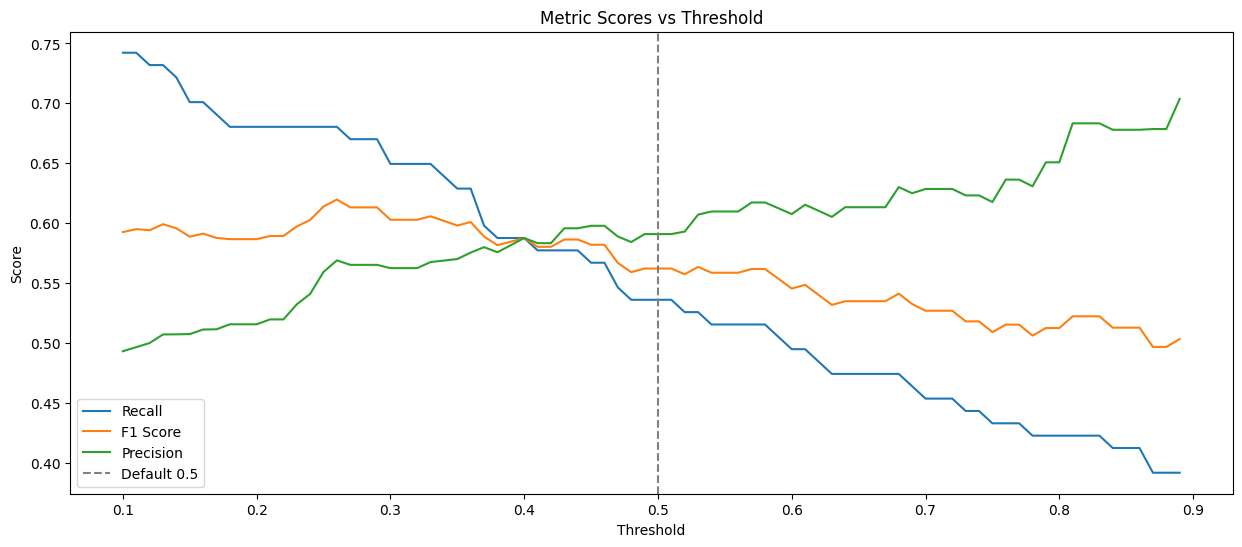

In [31]:
y_prob_ensemble = stacked_model_xgb.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_prob_ensemble >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    results.append((thresh, precision, recall, f1))

threshold_results = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1"])

plt.figure(figsize=(15,6))
plt.plot(threshold_results["Threshold"], threshold_results["Recall"], label="Recall")
plt.plot(threshold_results["Threshold"], threshold_results["F1"], label="F1 Score")
plt.plot(threshold_results["Threshold"], threshold_results["Precision"], label="Precision")
plt.axvline(x=0.5, color='grey', linestyle='--', label='Default 0.5')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metric Scores vs Threshold")
plt.legend()
plt.show()


#### Insights

**1. Recall (Blue Line)**
- Highest at lower thresholds (around 0.1 to 0.2), meaning more actual buyers (class 1) are being captured.

- Sharp drop after ~0.35–0.4 — meaning threshold beyond that misses many potential buyers.

- If capturing buyers is the priority (e.g., minimize false negatives), lower thresholds are favorable.

**2. Precision (Green Line)**

- Increases steadily with higher thresholds, peaking after 0.7.

- This means fewer false positives at high thresholds, but at the cost of missing many real buyers (low recall).

- Useful when false positives are expensive (e.g., wasted marketing effort).

**3. F1 Score (Orange Line)**
- Peaks around 0.25 to 0.3 – this is typically your sweet spot balancing precision and recall.

- After ~0.3, F1 begins to decline as recall drops faster than precision improves.

**Action**
- Due to class imbalance we will priotize best `F1 - Score` and `weighted average accuracy` as metrics for our model performance


### Final Model

In [32]:
y_probs_best = stacked_model_xgb_best.predict_proba(X_test)[:, 1]

optimal_threshold = 0.48
y_pred_best = (y_probs_best >= optimal_threshold).astype(int)

conf_matrix_best_thresh = pd.DataFrame(
    confusion_matrix(y_test, y_pred_best),
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)

class_report_best_thresh = classification_report(
    y_test, y_pred_best, output_dict=True
)
class_report_best_thresh_df = pd.DataFrame(class_report_best_thresh).transpose()

roc_auc_best_thresh = roc_auc_score(y_test, y_probs_best)

conf_matrix_best_thresh, class_report_best_thresh_df, roc_auc_best_thresh


(          Predicted 0  Predicted 1
 Actual 0          129           24
 Actual 1           48           49,
               precision    recall  f1-score  support
 0              0.728814  0.843137  0.781818  153.000
 1              0.671233  0.505155  0.576471   97.000
 accuracy       0.712000  0.712000  0.712000    0.712
 macro avg      0.700023  0.674146  0.679144  250.000
 weighted avg   0.706472  0.712000  0.702143  250.000,
 0.713664847382252)

#### Insights

**Threshold = 0.48**

Weighted Precision (↑ 0.7065)
- Reflects how reliable positive predictions are across both classes.

- Improved from 0.6939 (pre-threshold) → 0.7065, indicating fewer false positives, particularly for the minority class (1).

Weighted Recall (↑ 0.7120)
- Captures the model’s sensitivity — i.e., how well it detects both classes.

- Boosted from 0.7000 to 0.7120, showing the model is better at identifying actual positives, especially in imbalanced scenarios.

Weighted F1-Score (↑ 0.7021)
- The harmonic mean of weighted precision and recall.

- Improved from 0.6866 (pre-threshold) → 0.7021, confirming that threshold tuning offered a net performance gain without sacrificing class balance.

AUC remains stable at 0.7137
- Indicates that threshold tuning preserved the model’s ability to discriminate between classes.


### Model Validation

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    stacked_model_xgb_best,
    X_train_sm, y_train_sm, 
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)

print("Cross-Validated ROC AUC Scores:", cv_scores)
print("Mean ROC AUC:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

Cross-Validated ROC AUC Scores: [0.74079582 0.74236972 0.80081301 0.80124617 0.71601359]
Mean ROC AUC: 0.7602476624526341
Standard Deviation: 0.0345863338602876


#### Interpretation

- `Mean ROC AUC = 0.76`: This confirms that the tuned ensemble model has strong discriminative ability. ROC AUC > 0.75 is considered very good, especially in imbalanced classification scenarios like this.

- `Standard Deviation = 0.0346`: This is low, indicating stable performance across the 5 folds. The model generalizes well and isn't overfitting to particular folds.

- Range: Even the `lowest fold (0.7160)` still demonstrates decent separability.

#### Feature Importance

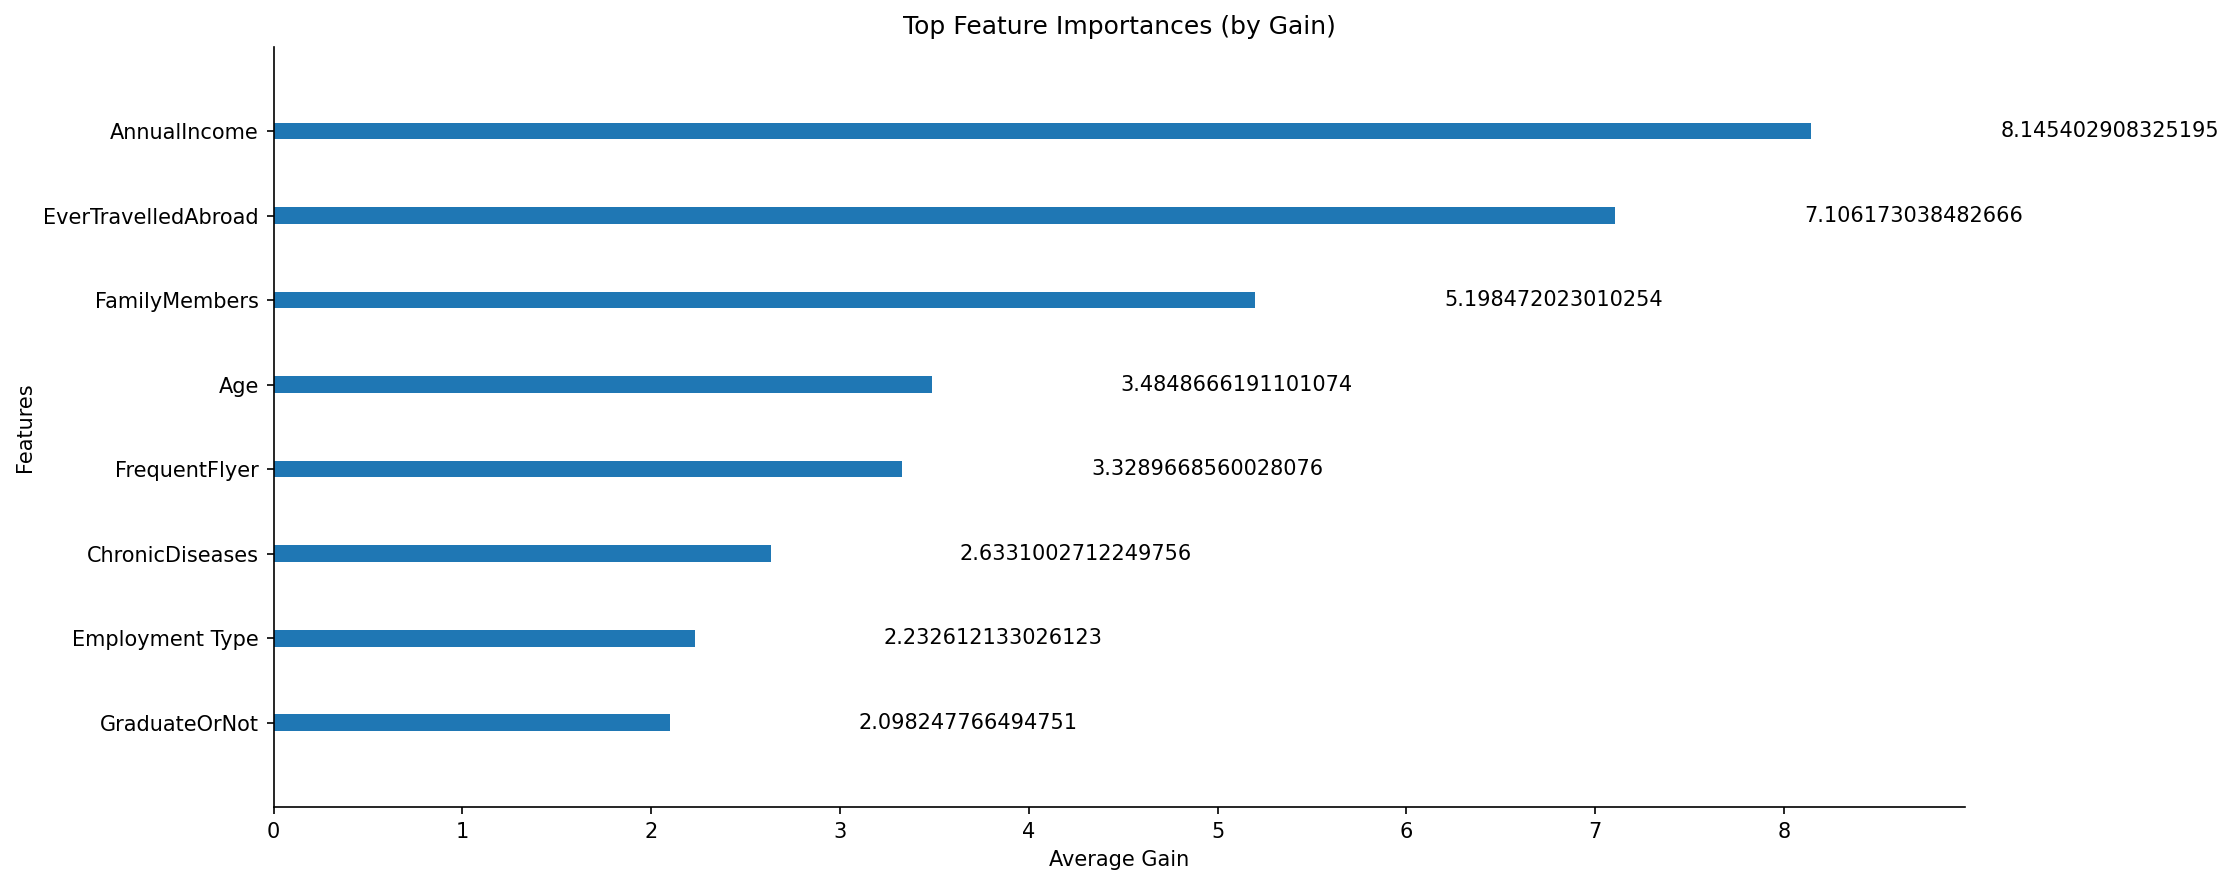

In [34]:

xgb_meta_best.fit(X_train_sm, y_train_sm)

fig, ax = plt.subplots(figsize=(15, 6), dpi=150)

plot_importance(xgb_meta_best, importance_type='gain', 
                max_num_features=10,
                xlabel='Average Gain',
                title='Top Feature Importances (by Gain)',
                show_values=True,
                ax=ax)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Insights

**`AnnualIncome - 8.15`**	
- Most important driver. Higher income likely reflects financial capability and greater perceived value of risk coverage during travel.

**`EverTravelledAbroad - 7.11`**
- Strong signal: those with prior international travel may be more aware of travel risks and more inclined to insure.

**`FamilyMembers - 5.20`**
- Suggests larger families might prioritize insurance more—likely due to higher aggregate risk or dependents.

**`Age - 3.48`**
- Age appears moderately predictive; older individuals may perceive higher health/travel risk.

**`FrequentFlyer - 3.33`**
- Frequent travelers likely understand the necessity or convenience of coverage.

**`ChronicDiseases - 2.63`**
- People with chronic conditions may seek travel insurance for peace of mind or out of necessity.

**`Employment Type - 2.23`**
- Some employment sectors (e.g., private or field-based jobs) may influence travel behavior and risk attitude.

**`GraduateOrNot - 2.10`**
- Least predictive among the eight, though it might correlate slightly with awareness or income.

## Conclusion


#### Key business insights:

- Financial and behavioral indicators like income, past travel, and family size are top predictors of insurance uptake.

- Targeting strategies should prioritize customers with high income, international travel history, larger families, and chronic health conditions.